In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import torch

In [3]:
from ACAgraphML.Dataset import ZINC_Dataset

NUM_NODE_FEATS = 28
NUM_EDGE_FEATS = 4

trainDataset = ZINC_Dataset.SMALL_TRAIN.load()
valDataset = ZINC_Dataset.SMALL_VAL.load()

In [14]:
len(trainDataset), len(valDataset), torch.min(trainDataset.data.y), torch.max(trainDataset.data.y)

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


(10000, 1000, tensor(-42.0366), tensor(3.8048))

Target statistics: mean=0.0153, std=2.0109
Range: [-42.0366, 3.8048]


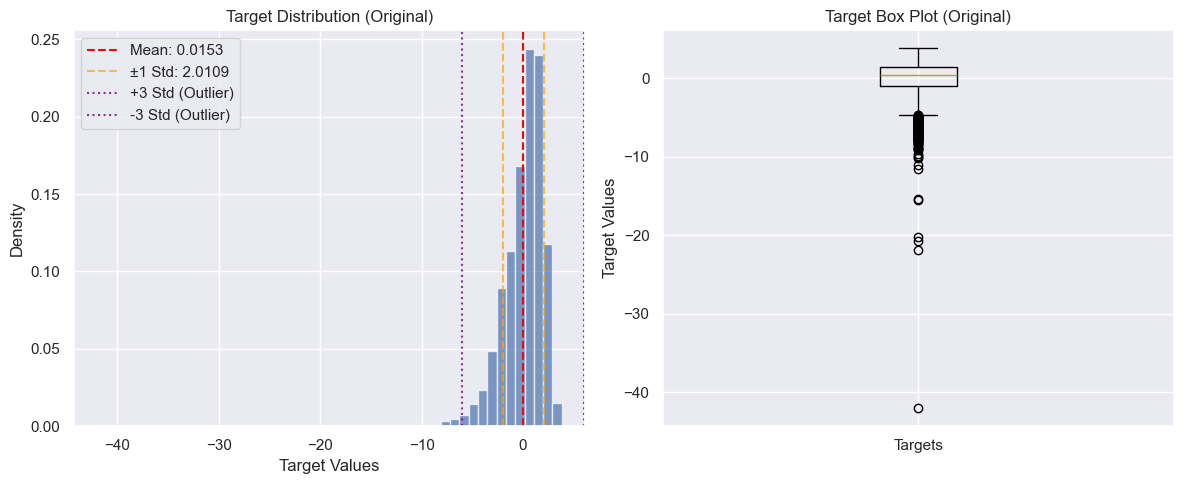

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Normalizing targets:   0%|          | 0/9893 [00:00<?, ?it/s]

Normalizing targets:   0%|          | 0/989 [00:00<?, ?it/s]


Dataset sizes after filtering:
Training: 9893 (was 10000)
Validation: 989 (was 1000)

=== Testing normalization ===
Sample train target: 0.8350
Sample val target: 0.6299


(9893, 989)

In [17]:
from ACAgraphML.Pipeline import TargetNormalizer

# Create the normalizer and fit it to the training data
target_normalizer = TargetNormalizer(verbose=True)
target_normalizer.fit(trainDataset)

# Create filtered and normalized datasets
normalized_train_dataset = target_normalizer.normalize(trainDataset)
normalized_val_dataset = target_normalizer.normalize(valDataset)

print(f"\nDataset sizes after filtering:")
print(f"Training: {len(normalized_train_dataset)} (was {len(trainDataset)})")
print(f"Validation: {len(normalized_val_dataset)} (was {len(valDataset)})")

# Test that the normalization works
print(f"\n=== Testing normalization ===")
sample_train = normalized_train_dataset[0]
sample_val = normalized_val_dataset[0]
print(f"Sample train target: {sample_train.y.item():.4f}")
print(f"Sample val target: {sample_val.y.item():.4f}")

len(normalized_train_dataset), len(normalized_val_dataset)

In [15]:
from ACAgraphML.Transforms import SteadyStateTransform, OneHotEncodeFeat, OneHotEdgeFeats, AddMasterNode
from ACAgraphML.Pipeline import DataAugmenter
from torch_geometric.transforms import AddRandomWalkPE, AddLaplacianEigenvectorPE

addMasterNodeTransform = AddMasterNode()
oneHotEncodeFeatTransform = OneHotEncodeFeat(nClasses=NUM_NODE_FEATS)
oneHotEncodeFeatTransformEdge = OneHotEdgeFeats(nClasses=NUM_EDGE_FEATS)
steadyStateTransform = SteadyStateTransform(useEdgeWeights=False)
randomWalkPETransform = AddRandomWalkPE(walk_length=10, attr_name=None)
lapEigvecs = AddLaplacianEigenvectorPE(k=5, attr_name=None, normalization='sym', is_undirected=True)

transforms = [
    addMasterNodeTransform,
    oneHotEncodeFeatTransform,
    oneHotEncodeFeatTransformEdge,
    steadyStateTransform,
    randomWalkPETransform,
    lapEigvecs
]

trainAugmented = DataAugmenter(
    dataset=normalized_train_dataset,
    transforms=transforms
).augment()

valAugmented = DataAugmenter(
    dataset=normalized_val_dataset,
    transforms=transforms
).augment()

trainAugmented.x.shape, trainAugmented[0].x.shape, valAugmented.x.shape, valAugmented[0].x.shape 

Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/989 [00:00<?, ?it/s]

(torch.Size([239124, 44]),
 torch.Size([30, 44]),
 torch.Size([23844, 44]),
 torch.Size([36, 44]))

Number of components to keep: 23
Explained variance ratio: 0.9999186396598816
Using saved principal directions.


(torch.Size([239124, 23]),
 torch.Size([30, 23]),
 torch.Size([23844, 23]),
 torch.Size([36, 23]))

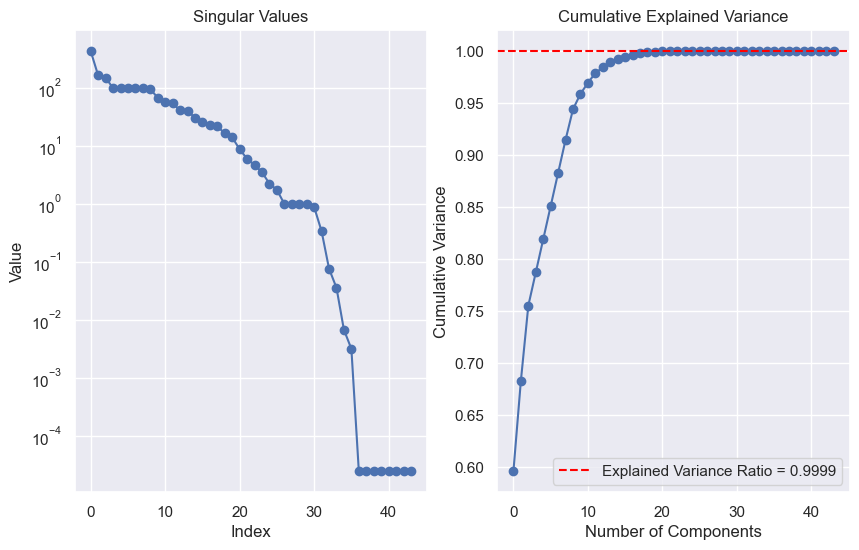

In [16]:
from ACAgraphML.Pipeline import DimentionalityReduction
dimentionalityReduction = DimentionalityReduction(explained_variance_ratio=0.9999, verbose=True)

trainDatasetReduced = dimentionalityReduction(trainAugmented)
valDatasetReduced = dimentionalityReduction(valAugmented, useState=True)

REDUCED_NUM_NODE_FEATS = trainDatasetReduced[0].x.shape[1]

trainDatasetReduced.x.shape, trainDatasetReduced[0].x.shape, valDatasetReduced.x.shape, valDatasetReduced[0].x.shape

In [18]:
from ACAgraphML.Pipeline.LightningModules import GDLPipelineLightningModule, create_lightning_baseline, create_lightning_standard

GDLPipeline = create_lightning_standard(REDUCED_NUM_NODE_FEATS, NUM_EDGE_FEATS, loss='mae')

print(GDLPipeline)

GDLPipelineLightningModule(
  (pipeline): GDLPipeline(
    (gnn): GNNModel(
      (input_proj): Linear(in_features=23, out_features=128, bias=True)
      (gnn_layers): ModuleList(
        (0-3): 4 x GINEConv(nn=Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
        ))
      )
      (layer_norms): ModuleList(
        (0-3): 4 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (dropouts): ModuleList(
        (0-3): 4 x Dropout(p=0.15, inplace=False)
      )
    )
    (pooling): Pooling(
      (pooling_layer): AttentionalPooling(
        (attention_layer): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Tanh()
          (2): Linear(in_features=128, out_features=1, bias=True)
        )
      )
    )
    (graph_dropout): Dropout(p=0.1, inplace=False)
    (graph_batch_norm): BatchNorm1d(128, eps=1e-05, mom

In [19]:
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader

# Create data loaders
train_loader = DataLoader(trainDatasetReduced, batch_size=32, shuffle=True)
val_loader = DataLoader(valDatasetReduced, batch_size=32, shuffle=False)

pl.seed_everything(42)

callbacks= [
    pl.callbacks.ModelCheckpoint(
        monitor='val_loss',
        filename='best_model',
        save_top_k=1,
        mode='min',
        save_weights_only=True
    ),
    pl.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
    )
]


# Create trainer
trainer = pl.Trainer(
    default_root_dir='./saved_models/Pipeline/Standard',  # Specify custom log directory
    max_epochs=50,
    accelerator='auto',
    devices=1,
    log_every_n_steps=10,
    callbacks=callbacks,
    enable_progress_bar=True,
)

# Train the model
trainer.fit(GDLPipeline, train_loader, val_loader)

bestModel = GDLPipelineLightningModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | pipeline | GDLPipeline | 312 K  | train
1 | loss_fn  | L1Loss      | 0      | train
-------------------------------------------------
312 K     Trainable params
0         Non-trainable params
312 K     Total params
1.250     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

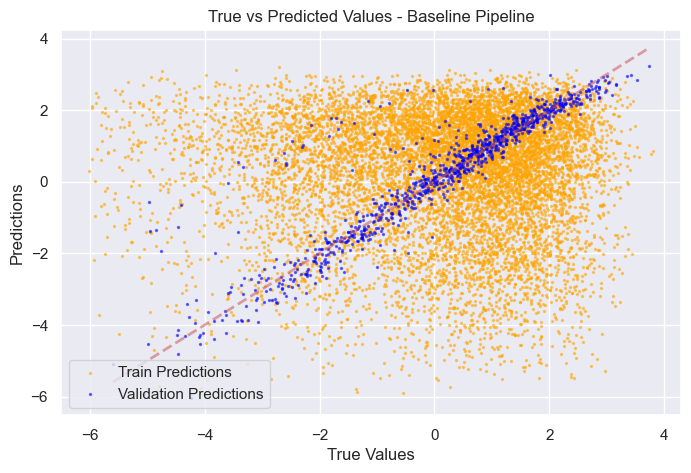

In [20]:
from ACAgraphML.utils import plotTrueVsPred
bestModel = GDLPipelineLightningModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

trainPredictions = [
    bestModel.predict(batch.x,
                      edge_index=batch.edge_index,
                      edge_attr=batch.edge_attr,
                      batch=batch.batch
                      ) for batch in train_loader
]
valPredictions = [
    bestModel.predict(batch.x,
                      edge_index=batch.edge_index,
                      edge_attr=batch.edge_attr,
                      batch=batch.batch
                      ) for batch in val_loader
]

# Collect all predictions and targets
train_predictions_concat = torch.cat(trainPredictions)
val_predictions_concat = torch.cat(valPredictions)

# Collect all targets
train_targets = torch.cat([batch.y for batch in train_loader])
val_targets = torch.cat([batch.y for batch in val_loader])

plotTrueVsPred(train_targets, train_predictions_concat, val_targets, val_predictions_concat, title='True vs Predicted Values - Baseline Pipeline', filename='./saved_models/Pipeline/Standard/true_vs_pred_baseline.png', hardLimit=False)
